# KL Divergence Layers

> In this post, we will cover the easy way to handle KL divergence with tensorflow probability layer object. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/fashion_mnist_generated2.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### Samples
```python
latent_size=4
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

encoder = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior) # automatically add loss function into a model to be optimized later on
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_size,)),
    Dense(tfpl.IndependentNormal.params_size(12)),
    tfpl.IndepedentNormal(12)
])

vae = Model(inputs=encoder.input, outputs=decoder(encoder.output))
vae.compile(loss=lambda x, pred: -pred.log_prob(x))
vae.fit(train_data, epochs=20)
```

Or you can implement KL Divergence that can use exact value by using `use_exact_kl` keyword. Or you can also multiply weights in KL term.

```python
encoder = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=10) # Use MC sampling for KL divergence, then weight it by 10 
])
```

```python
encoder = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size,
                                convert_to_tensor_fn=tfp.distributions.Distribution.sample),
    tfpl.KLDivergenceAddLoss(prior) # automatically add loss function into a model to be optimized later on
])
```

In this case, the output of encoder will be the sample from multivariate normal distribution. Note that, above example is for Computing KL divergence. If you use `convert_to_tensor_fn` to `mean` or `mode`, then it will be the tensor that would be used in the approximation.

```python
encoder = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=10,
                             test_points_fn=lambda q: q.sample(10), # 10 samples for test points
                             test_points_reduce_axis=0) # automatically add loss function into a model to be optimized later on
])
```
So at that case, test point function is required to compute the estimation.

Alternative way to implement KL divergence is to use `KLDivergenRegularizer` for the regularizer.

```python
encoder = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size,
                                activity_regularizer=tfpl.KLDivergenceRegularizer(
                                    prior, weight=10, use_exact_kl=False,
                                    test_points_fn=lambda q: q.sample(10),
                                    test_points_reduce_axis=0))
])
```

## Tutorial

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape

In [5]:
# Import fashion MNIST

(X_train, _), (X_test, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 256. + 0.5 / 256
X_test = X_test.astype('float32') / 256. + 0.5 / 256
example_X = X_test[:16]

batch_size = 32
X_train = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(batch_size)
X_test = tf.data.Dataset.from_tensor_slices((X_test, X_test)).batch(batch_size)

In [6]:
# Define latent_size and the prior, p(z)

latent_size = 4
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [7]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer

event_shape = (28, 28)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior) # estimate KL[ q(z|x) || p(z)]
])

# Samples z_j from q(z | x_j)
# then computes log q(z_j | x_j) - log p(z_j)

In [8]:
# See how `KLDivergenceAddLoss` affects `encoder.losses`
# encoder.losses before the network has received any inputs

encoder.losses

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [9]:
# Pass a batch of images through the encoder

encoder(example_X)

<tfp.distributions.MultivariateNormalTriL 'sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[16] event_shape=[4] dtype=float32>

In [10]:
# See how encoder.losses has changed

encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.4207765>]

In [11]:
# Re-specify the encoder using `weight` and `test_points_fn`

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior,
                             use_exact_kl=False,
                             weight=1.5,
                             test_points_fn=lambda q: q.sample(10),
                             test_points_reduce_axis=0) # estimate KL[ q(z|x) || p(z)]
])

# (n_samples, batch_size, dim_z)
# z_{ij} is the ith sample for x_j (is at (i, j, :) in tensor of samples)
# is mapped to log q(z_{ij}|x_j) - log p(z_{ij})
# => tensor of KL Divergences has sape (n_samples, batch_size)

In [12]:
# Replacing `KLDivergenceAddLoss` with `KLDivergenceRegularizer` in the previous layer
divergence_regularizer = tfpl.KLDivergenceRegularizer(prior,
                                                      use_exact_kl=False,
                                                      test_points_fn=lambda q: q.sample(5),
                                                      test_points_reduce_axis=0)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size,
                                activity_regularizer=divergence_regularizer),
])

In [13]:
# Specify the decoder, p(x|z)

decoder = Sequential([
    Dense(16, activation='relu', input_shape=(latent_size,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2*event_shape[0]*event_shape[1], activation='exponential'),
    Reshape((event_shape[0], event_shape[1], 2)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Beta(concentration1=t[..., 0],
                     concentration0=t[..., 1])
        )
    )
])

> Note: If you faced the error like this "NotImplementedError: Cannot convert a symbolic Tensor (gradients/stateless_random_gamma/StatelessRandomGammaV2_grad/sub:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported", this is the problem on numpy side. You need to install numpy with `1.19.x` instead of `1.20.x`. See the [reference](https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy).

In [14]:
# Connect the encoder and decoder to form the VAE

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [15]:
# Define a loss that only estimate the expected reconstruction error,
# -E_{z ~ q(z | x)}[log p(x | z)]

def log_loss(X_true, p_x_given_z):
    return -tf.reduce_sum(p_x_given_z.log_prob(X_true))

In [16]:
# Compile and fit the model

vae.compile(loss=log_loss)
vae.fit(X_train, validation_data=X_test, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: -53792.4219 - val_loss: -63781.0430
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: -63665.5078 - val_loss: -64181.7930
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: -66448.9219 - val_loss: -67975.6172
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: -68327.5859 - val_loss: -70727.4141
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: -70031.3906 - val_loss: -70685.8516
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: -71203.7734 - val_loss: -64922.7461
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: -72169.3125 - val_loss: -73782.7109
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: -73042.2422 - val_loss: -70419.5547
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: -73685.4453 - val_l

In [18]:
# Generate an example reconstruction

example_reconstruction = vae(example_X).mean().numpy().squeeze()

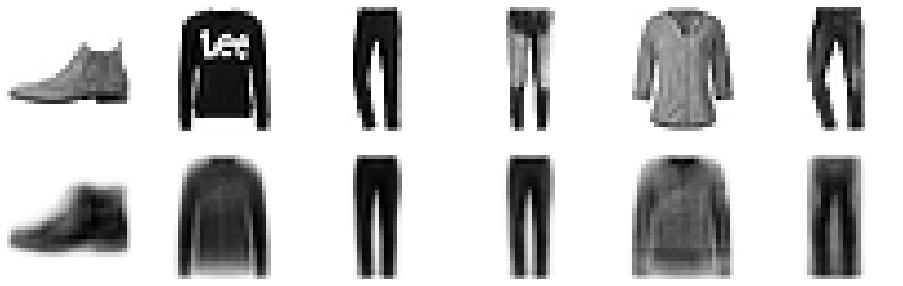

In [20]:
# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :].squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

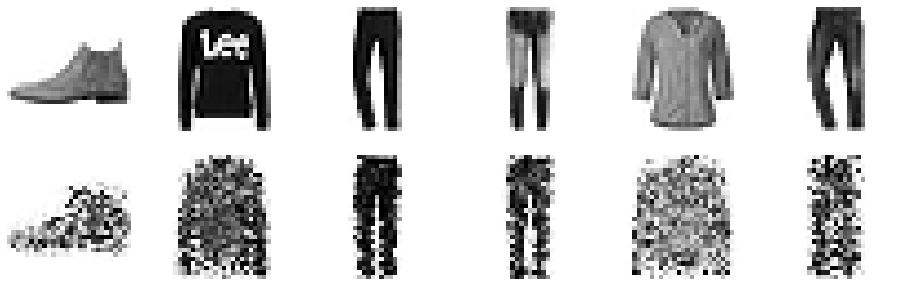

In [21]:
# Generate an example reconstruction

example_reconstruction = vae(example_X).sample().numpy().squeeze()

# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :].squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')